In [2]:
#!pip install scikit-learn


In [3]:
# import openai libraries
from openai import OpenAI
import pandas as pd

In [4]:
import json


client = OpenAI()

def get_embedding(text):
    response = client.embeddings.create(
        input=text,
        model="text-embedding-3-small"
    )
    return response.data[0].embedding

In [5]:
# test the function, and print embedding shape for sample text
#text = "We are at Fort Lewis in Durango, Colorado in a session about embeddings."
text = ""

embedding = get_embedding(text)
print(f"Embedding shape: {len(embedding)}")
# pretty print the embedding with line breaks, etc
from pprint import pprint
pprint(embedding, indent=2, width=80)


Embedding shape: 1536
[ 0.01536838710308075,
  -0.03481070324778557,
  -0.009328825399279594,
  0.014480682089924812,
  0.007343378383666277,
  0.014409349299967289,
  -0.05224776268005371,
  0.049235906451940536,
  -0.01359297800809145,
  0.015106831677258015,
  0.008250897750258446,
  0.03281337022781372,
  -0.041722118854522705,
  -0.015447646379470825,
  0.020306244492530823,
  0.06340747326612473,
  -0.045526567846536636,
  0.027027437463402748,
  -0.0077634528279304504,
  0.01865765079855919,
  0.07437697052955627,
  0.014821497723460197,
  -0.016676167026162148,
  -0.0307367742061615,
  0.04010522738099098,
  -0.014940386638045311,
  0.003134707221761346,
  -0.011730383150279522,
  0.027534697204828262,
  -0.05890554562211037,
  0.044797383248806,
  -0.04248300939798355,
  0.00369546702131629,
  -0.018150391057133675,
  -0.018404019996523857,
  0.056464359164237976,
  0.024728916585445404,
  0.00309309596195817,
  0.025759287178516388,
  0.026868918910622597,
  -0.00359044829383

In [6]:
# read json objects, line by line, in json/data-barn-delights.jsonl into a dataframe
df = pd.read_json('json/data-barn-delights.jsonl', lines=True)

In [7]:
# create a new column, named embedding in the dataframe calling get_embedding for text column
df['embedding'] = df['text'].apply(get_embedding)


In [11]:
df

,id,meta_color,meta_department,text,embedding
0,apple,red,grocery,This fresh red apple is perfect for snacking o...,"[0.004357376601547003, -0.015314856544137001, ..."
1,asparagus,green,grocery,This fresh green asparagus is ideal for health...,"[0.0060213059186935425, -0.024946179240942, 0...."
2,blueberries,blue,grocery,These fresh blue blueberries are perfect for s...,"[0.00741775194182992, -0.026721514761447906, -..."
3,fertilizer,green,garden,This green fertilizer boosts plant growth and ...,"[0.013712795451283455, 0.0327032133936882, 0.0..."
4,frozen-peas,green,grocery,These green frozen peas are a versatile and he...,"[-0.015473926439881325, -0.03986012190580368, ..."
5,mop,red,cleaning,This red mop is designed for efficient floor c...,"[0.05619010701775551, 0.03280946984887123, -0...."
6,pasta-sauce,red,grocery,This red pasta sauce is perfect for adding fla...,"[-0.05282636731863022, -0.037101104855537415, ..."
7,planting-bed,red,garden,This red planting bed is ideal for creating or...,"[0.0010808962397277355, -0.021274976432323456,..."
8,sponge,green,cleaning,This green sponge is perfect for all your clea...,"[0.028249232098460197, 0.011501634493470192, 0..."
9,sports-drink,blue,grocery,This blue sports drink is designed to keep you...,"[0.03546168655157089, 0.03785005956888199, -0...."


Available IDs: ['apple' 'asparagus' 'blueberries' 'fertilizer' 'frozen-peas' 'mop'
 'pasta-sauce' 'planting-bed' 'sponge' 'sports-drink' 'watering-can'
 'window-cleaner']


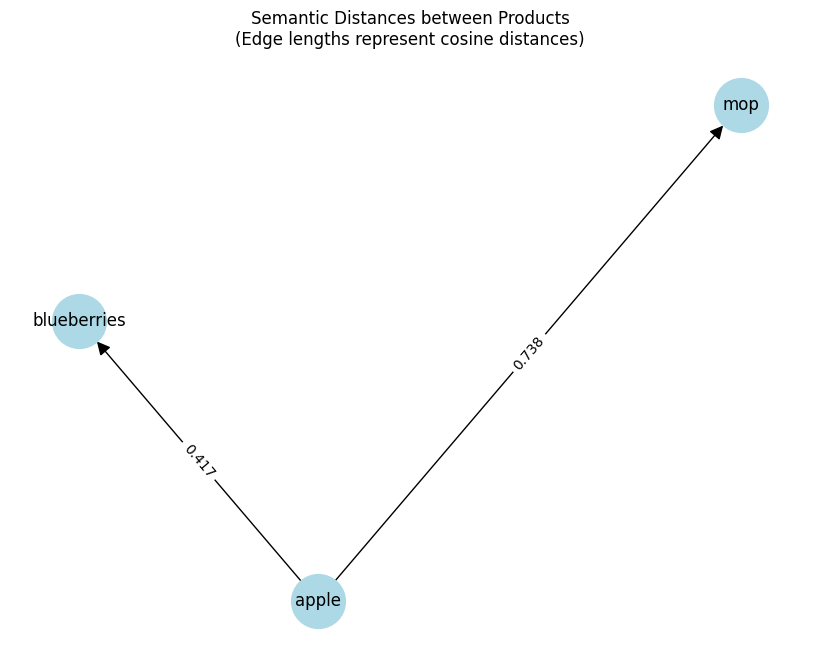

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Create a directed graph
G = nx.DiGraph()

# First verify the items exist in the dataframe
print("Available IDs:", df['id'].unique())

# Get embeddings for apple, mop and blueberries with error checking
apple_data = df[df['id'] == 'apple']
mop_data = df[df['id'] == 'mop']
blueberries_data = df[df['id'] == 'blueberries']

if len(apple_data) == 0 or len(mop_data) == 0 or len(blueberries_data) == 0:
    print("Error: Could not find one or more products in the dataset")
else:
    apple_embedding = apple_data['embedding'].values[0]
    mop_embedding = mop_data['embedding'].values[0]
    blueberries_embedding = blueberries_data['embedding'].values[0]

    # Calculate cosine similarities
    apple_mop_sim = cosine_similarity([apple_embedding], [mop_embedding])[0][0]
    apple_blueberries_sim = cosine_similarity([apple_embedding], [blueberries_embedding])[0][0]

    # Add nodes and edges with distances
    G.add_edge('apple', 'mop', weight=1-apple_mop_sim)
    G.add_edge('apple', 'blueberries', weight=1-apple_blueberries_sim)

    # Draw the graph
    plt.figure(figsize=(8, 6))
    
    # Create a custom layout where edge lengths correspond to cosine distances
    pos = {}
    pos['apple'] = np.array([0, 0])  # Place apple at origin
    
    # Calculate positions for other nodes based on distances
    angle_mop = np.pi/3  # 60 degrees
    angle_blueberries = 2*np.pi/3  # 120 degrees
    
    # Scale factor to make distances more visible
    scale = 2.0
    
    # Position nodes using polar coordinates, where distance = cosine distance
    pos['mop'] = np.array([
        scale * (1-apple_mop_sim) * np.cos(angle_mop),
        scale * (1-apple_mop_sim) * np.sin(angle_mop)
    ])
    pos['blueberries'] = np.array([
        scale * (1-apple_blueberries_sim) * np.cos(angle_blueberries),
        scale * (1-apple_blueberries_sim) * np.sin(angle_blueberries)
    ])

    nx.draw(G, pos, with_labels=True, node_color='lightblue', 
            node_size=1500, arrowsize=20, font_size=12)

    # Add edge labels (distances)embedding_overview.png
    edge_labels = nx.get_edge_attributes(G, 'weight')
    edge_labels = {k: f'{v:.3f}' for k, v in edge_labels.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title('Semantic Distances between Products\n(Edge lengths represent cosine distances)')
    plt.show()
